# BiLSTM으로 한국어 스팀 리뷰 감성 분류하기
https://wikidocs.net/94748

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
# from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Load dataset

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7ffcfae27a20>)

In [3]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data))
total_data[:5]

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


전체 리뷰 개수 : 100000


,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [4]:
len(total_data["label"].unique()), len(total_data["reviews"].unique())

(2, 99892)

In [5]:
total_data.drop_duplicates(subset=["reviews"], inplace=True)
len(total_data)

99892

In [6]:
total_data.isnull().values.any()

False

## Split train, test dataset

In [7]:
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=0)
train_data.shape, test_data.shape

((74919, 2), (24973, 2))

,label,count
0,0,37439
1,1,37480


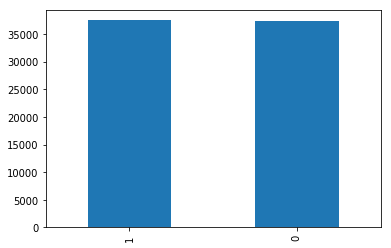

In [8]:
train_data['label'].value_counts().plot(kind = 'bar')
train_data.groupby('label').size().reset_index(name = 'count')

## Text preprocessing

In [ ]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [ ]:
def text_preprocessing(df, text_col):
    
    # 한글과 공백을 제외한 문자 제거
    df[text_col] = df[text_col].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
    df[text_col].replace("", np.nan, inplace=True)
    df = df.dropna(how="any")
    print(f"Num of samples: {len(df)}")
    
    # Tokenize
    df["tokenized"] = df[text_col].apply(mecab.morphs)
    df["tokenized"] = df["tokenized"].apply(lambda x: [item for item in x not in stopwords])
    
    return df

In [ ]:
train_data = text_preprocessing(train_data, "reviews")
test_data = text_preprocessing(test_data, "reviews")

### 단어와 길이 분포 확인하기

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

### 정수 인코딩

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(toeknizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

